# 1. Installing libraries, Configuring GPUs

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install tensorflow opencv-python matplotlib
#tensorflow -> deep learning pipeline 
#tensorflow-metal is for activating gpus (doesnt work n doesnt matter for intel chips)
#opencv -> will be used to remove unclear images, read images etc. 
#matplotlib -> visualize images/data

In [ ]:
!pip show tensorflow

In [ ]:
!pip list

In [5]:
import tensorflow as tf
import os
#os is used to create paths, list directories and other functions that adjusts appropriately according to the operating system

2024-03-06 01:22:26.230207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
!pip install tensorflow-macos

In [7]:
!pip install tensorflow-metal

In [8]:
# no GPUs on this macbook
devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)
gpus = tf.config.list_physical_devices('GPU')
gpus
if gpus:
    details = tf.config.experimental.get_device_details(gpus[0])
    print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [9]:
import cv2 as cv 
from matplotlib import pyplot as plt 

In [10]:
datapath = 'Star-Galaxy Dataset'

In [ ]:
os.listdir(os.path.join(datapath, 'star'))
os.listdir(os.path.join(datapath, 'galaxy'))

In [12]:
#cv.imread('Star-Galaxy Dataset/star/grb0422a_01_104_1014_6.jpg')
img = cv.imread(os.path.join(datapath, 'star', 'grb0422a_01_104_1014_6.jpg'))
img.shape

(64, 64, 3)

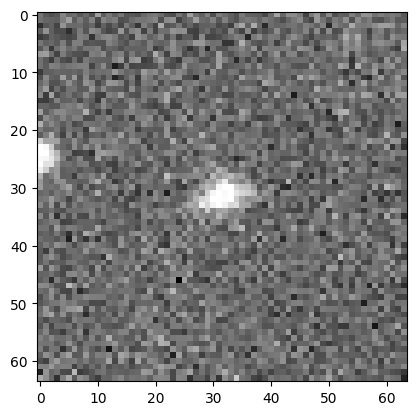

In [13]:
#opencv processes in bgr not rgb so it messes with colors of original pic
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB)) 
plt.show()

In [ ]:
data = tf.keras.utils.image_dataset_from_directory??

In [15]:
#does the labelled dataset for you & a bunch of preprocessing including resizing
#******** may want to try different resizing metrics, batch sizes etc. *********
data = tf.keras.utils.image_dataset_from_directory(datapath)

Found 3993 files belonging to 2 classes.


In [16]:
import numpy as np

In [17]:
# this allows us to access the generator from the data pipeline, data[0] etc.
# allows us to access/loop through batches
data_array = data.as_numpy_iterator()
data_array

In [18]:
#this grabs a batch, which is set to 32 images by default as per the keras.utils metrics
batch = data_array.next()
batch[0].shape

(32, 256, 256, 3)

In [19]:
#its of length 2 because it splits data to images and labels
# so batch[0] has images, batch[1] has labels
len(batch)
batch[0]
batch[1]

array([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [20]:
batch[0].max()

255.0

In [21]:
#shows which class label is 0 or 1
for i, class_name in enumerate(data.class_names):
    print(f"{class_name}: {i}")

galaxy: 0
star: 1


# 2. Data Preprocessing

In [ ]:
data.map??

In [23]:
# we will use the function .map to rescale the images from 0 to 255 to 0 to 1 as it allows better results
# map functiond allows transformations on the data in the data pipeline so that it is applied everytime a batch is loaded
# speeds up how quickly we can access our data & does it throughout the pipeline
data = data.map(lambda x, y: (x/255, y))

In [24]:
data_array = data.as_numpy_iterator()
batch = data_array.next()
batch[0].max()

1.0

# 3. Splitting Data into Train, Test & Validation

In [25]:
len(data)
# so we have 125 batches, each with 32 images
# we will split it accordingly --> 70% train, 20% validation, 10% test

125

In [26]:
train_size = int(len(data)*0.7)
train_size

87

In [27]:
#had to add 1 so that train+val+test add up to the total number of batches
#the reason it doesnt do that naturally is because we're converting to int
val_size = int(len(data)*0.2)+1
val_size

26

In [28]:
test_size = int(len(data)*0.1)
test_size

12

In [29]:
train_size + val_size + test_size

125

In [30]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + test_size).take(test_size)

In [31]:
len(train)

87

In [32]:
len(val)

26

In [33]:
len(test)

12

In [34]:
y = batch[1]
len(y)

32

In [35]:
#or we can use scikit-learn
from sklearn.model_selection import train_test_split
y = batch[1]
X_train, X_test, y_train, y_test = train_test_split(batch[0], y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(24, 256, 256, 3)
(8, 256, 256, 3)
(24,)
(8,)


# 4. Building CNN Model

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Flatten, Dense, Conv2D, MaxPooling2D

In [41]:
#input layer size = images reshaped by keras.utils
model = Sequential([Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)),
                    MaxPooling2D(), 
                    Conv2D(32, (3,3), 1, activation='relu'),
                    MaxPooling2D(), 
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(1, activation='sigmoid')
                    ])

In [42]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics =['accuracy'])

In [43]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 123008)            0         
                                                                 
 dense_8 (Dense)             (None, 256)              

# 5. Train

In [44]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [45]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
87/87 [==============================] - 163s 2s/step - loss: 0.7526 - accuracy: 0.7425 - val_loss: 0.5523 - val_accuracy: 0.7680
Epoch 2/20
87/87 [==============================] - 152s 2s/step - loss: 0.5523 - accuracy: 0.7601 - val_loss: 0.5289 - val_accuracy: 0.7620
Epoch 3/20
87/87 [==============================] - 147s 2s/step - loss: 0.5333 - accuracy: 0.7557 - val_loss: 0.5155 - val_accuracy: 0.7692
Epoch 4/20
87/87 [==============================] - 118s 1s/step - loss: 0.5116 - accuracy: 0.7615 - val_loss: 0.4996 - val_accuracy: 0.7692
Epoch 5/20
87/87 [==============================] - 117s 1s/step - loss: 0.4452 - accuracy: 0.7827 - val_loss: 0.4731 - val_accuracy: 0.7800
Epoch 6/20
87/87 [==============================] - 112s 1s/step - loss: 0.3312 - accuracy: 0.8563 - val_loss: 0.4558 - val_accuracy: 0.7957
Epoch 7/20
87/87 [==============================] - 113s 1s/step - loss: 0.1978 - accuracy: 0.9239 - val_loss: 0.4733 - val_accuracy: 0.7776
Epoch 8/20
87

# 6. Plots

### 1. Loss

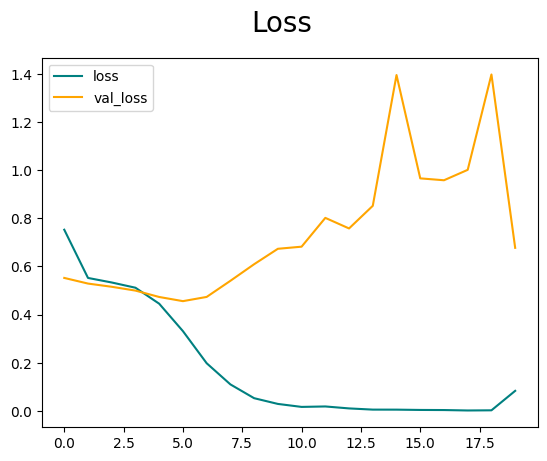

In [47]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### 2. Accuracy

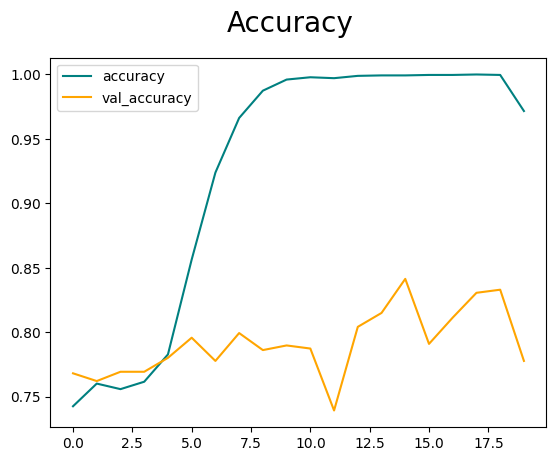

In [48]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [49]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy


In [50]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

print(pre.result(), re.result(), acc.result())


1/1 [==============================] - 0s 285ms/step
tf.Tensor(0.80906147, shape=(), dtype=float32) tf.Tensor(0.8680556, shape=(), dtype=float32) tf.Tensor(0.7473958, shape=(), dtype=float32)
